**Step 1 : Clone yolov5 repository**

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 10142, done.
remote: Total 10142 (delta 0), reused 0 (delta 0), pack-reused 10142
Receiving objects: 100% (10142/10142), 10.43 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (7030/7030), done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Step 2: Change Directory to yolov5**

In [ ]:
!pwd

/content


In [3]:
%cd /content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5

/content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5


**Step 3: Install Dependencies**

In [4]:
!pip install -U -r requirements.txt

     |████████████████████████████████| 11.2 MB 4.3 MB/s 
     |████████████████████████████████| 15.7 MB 41.0 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 3.1 MB 24.0 MB/s 
     |████████████████████████████████| 596 kB 69.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 11.3 MB 48.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pa

**Step 4: Run Object Detection on Images. Provide image path. Upload image in the inference/images/ folder**

In [5]:
!python detect.py --source "/content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5/data/images" --weights "/content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5/crowdhuman_yolov5m.pt" --conf 0.4

detect: weights=['/content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5/crowdhuman_yolov5m.pt'], source=/content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5/data/images, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 2021-9-1 torch 1.10.0+cu111 CPU

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 308 layers, 21041679 parameters, 0 gradients
image 1/2 /content/gdriv

In [7]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/pose-estimation-main/yolov5


#Test on video, change source and weight paths

In [10]:
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Run inference on images, videos, directories, streams, etc.

Usage:
    $ python path/to/detect.py --source path/to/img.jpg --weights yolov5s.pt --img 640
"""

import argparse
import sys
import time
from pathlib import Path
import cv2
import numpy as np
from numpy import random
import torch
import torch.backends.cudnn as cudnn

#FILE = Path(__file__).absolute()
#sys.path.append(FILE.parents[0].as_posix())  # add yolov5/ to path

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, colorstr, is_ascii, non_max_suppression, \
    apply_classifier, scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import Annotator, colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_sync


@torch.no_grad()
def run(weights='yolov5s.pt',  # model.pt path(s)
        source='',  # file/dir/URL/glob, 0 for webcam
        imgsz=640,  # inference size (pixels)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        view_img=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        nosave=False,  # do not save images/videos
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project='runs/detect',  # save results to project/name
        name='exp',  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=3,  # bounding box thickness (pixels)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        half=False,  # use FP16 half-precision inference
        ):
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(device)
    half &= device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    w = weights[0] if isinstance(weights, list) else weights
    classify, suffix = False, Path(w).suffix.lower()
    pt, onnx, tflite, pb, saved_model = (suffix == x for x in ['.pt', '.onnx', '.tflite', '.pb', ''])  # backend
    stride, names = 64, [f'class{i}' for i in range(1000)]  # assign defaults
    if pt:
        model = attempt_load(weights, map_location=device)  # load FP32 model
        stride = int(model.stride.max())  # model stride
        names = model.module.names if hasattr(model, 'module') else model.names  # get class names
        if half:
            model.half()  # to FP16
        if classify:  # second-stage classifier
            modelc = load_classifier(name='resnet50', n=2)  # initialize
            modelc.load_state_dict(torch.load('resnet50.pt', map_location=device)['model']).to(device).eval()
    elif onnx:
        check_requirements(('onnx', 'onnxruntime'))
        import onnxruntime
        session = onnxruntime.InferenceSession(w, None)
    else:  # TensorFlow models
        check_requirements(('tensorflow>=2.4.1',))
        import tensorflow as tf
        if pb:  # https://www.tensorflow.org/guide/migrate#a_graphpb_or_graphpbtxt
            def wrap_frozen_graph(gd, inputs, outputs):
                x = tf.compat.v1.wrap_function(lambda: tf.compat.v1.import_graph_def(gd, name=""), [])  # wrapped import
                return x.prune(tf.nest.map_structure(x.graph.as_graph_element, inputs),
                               tf.nest.map_structure(x.graph.as_graph_element, outputs))

            graph_def = tf.Graph().as_graph_def()
            graph_def.ParseFromString(open(w, 'rb').read())
            frozen_func = wrap_frozen_graph(gd=graph_def, inputs="x:0", outputs="Identity:0")
        elif saved_model:
            model = tf.keras.models.load_model(w)
        elif tflite:
            interpreter = tf.lite.Interpreter(model_path=w)  # load TFLite model
            interpreter.allocate_tensors()  # allocate
            input_details = interpreter.get_input_details()  # inputs
            output_details = interpreter.get_output_details()  # outputs
            int8 = input_details[0]['dtype'] == np.uint8  # is TFLite quantized uint8 model
    imgsz = check_img_size(imgsz, s=stride)  # check image size
    ascii = is_ascii(names)  # names are ascii (use PIL for UTF-8)

    # Dataloader
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt)
        bs = len(dataset)  # batch_size
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
        bs = 1  # batch_size
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    if pt and device.type != 'cpu':
        model(torch.zeros(1, 3, *imgsz).to(device).type_as(next(model.parameters())))  # run once
    
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    t0 = time.time()

    for path, img, im0s, vid_cap in dataset:
        if onnx:
            img = img.astype('float32')
        else:
            img = torch.from_numpy(img).to(device)
            img = img.half() if half else img.float()  # uint8 to fp16/32
        img = img / 255.0  # 0 - 255 to 0.0 - 1.0
        if len(img.shape) == 3:
            img = img[None]  # expand for batch dim

        # Inference
        t1 = time_sync()
        if pt:
            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred = model(img, augment=augment, visualize=visualize)[0]
        elif onnx:
            pred = torch.tensor(session.run([session.get_outputs()[0].name], {session.get_inputs()[0].name: img}))
        else:  # tensorflow model (tflite, pb, saved_model)
            imn = img.permute(0, 2, 3, 1).cpu().numpy()  # image in numpy
            if pb:
                pred = frozen_func(x=tf.constant(imn)).numpy()
            elif saved_model:
                pred = model(imn, training=False).numpy()
            elif tflite:
                if int8:
                    scale, zero_point = input_details[0]['quantization']
                    imn = (imn / scale + zero_point).astype(np.uint8)  # de-scale
                interpreter.set_tensor(input_details[0]['index'], imn)
                interpreter.invoke()
                pred = interpreter.get_tensor(output_details[0]['index'])
                if int8:
                    scale, zero_point = output_details[0]['quantization']
                    pred = (pred.astype(np.float32) - zero_point) * scale  # re-scale
            pred[..., 0] *= imgsz[1]  # x
            pred[..., 1] *= imgsz[0]  # y
            pred[..., 2] *= imgsz[1]  # w
            pred[..., 3] *= imgsz[0]  # h
            pred = torch.tensor(pred)

        # NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        t2 = time_sync()

        # Second-stage classifier (optional)
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process predictions
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], f'{i}: ', im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name) # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, pil=not ascii)
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in det:
                    label = '%s %.2f' % (names[int(cls)], conf)
                    x = xyxy
                    tl = None or round(0.002 * (im0.shape[0] + im0.shape[1]) / 2) + 1
                    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
                    x, y = c1
                    w, h = c2
                    label1 = label.split(' ')
                    if label1[0] == 'head':
                       
                      im0[y:h,x:w] = cv2.medianBlur(im0[y:h,x:w],27)

                      #cv2.rectangle(im0, (x,y), (w,h), (255,255,255), 1, cv2.LINE_AA)
					


                    #if save_img or save_crop or view_img:  # Add bbox to image
                     #   c = int(cls)  # integer class
                     #   label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        #xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()
                        #x,y,w,h = xywh
                        #plot_one_box(xyxy, im0, label=label, color=int(cls), line_thickness=3, name= names)

                        #annotator.box_label(xyxy, label, color=colors(c, True))
                        #if save_crop:
                        #    save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Print time (inference + NMS)
            print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            im0 = annotator.result()
            
            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # new video
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {colorstr('bold', save_dir)}{s}")

    if update:
        strip_optimizer(weights)  # update model (to fix SourceChangeWarning)

    print(f'Done. ({time.time() - t0:.3f}s)')




def main():
    #print(colorstr('detect: ') + ', '.join(f'{k}={v}' for k, v in vars(opt).items()))
    check_requirements(exclude=('tensorboard', 'thop'))
    weights = "/content/gdrive/MyDrive/Colab Notebooks/pose-estimation-main/yolov5/crowdhuman_yolov5m.pt"
    source = "/content/gdrive/MyDrive/Colab Notebooks/kexu.mp4"
    run(weights,source)


if __name__ == "__main__":
    #opt = parse_opt()
    main()


requirements: Pillow>=8.0.0 not found and is required by YOLOv5, attempting auto-update...

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-9-1 torch 1.10.0+cu111 CPU




requirements: 2 packages updated per /content/gdrive/My Drive/Colab Notebooks/pose-estimation-main/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 308 layers, 21041679 parameters, 0 gradients


video 1/1 (1/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (1.252s)
video 1/1 (2/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.686s)
video 1/1 (3/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.703s)
video 1/1 (4/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.734s)
video 1/1 (5/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.696s)
video 1/1 (6/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.697s)
video 1/1 (7/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.755s)
video 1/1 (8/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.781s)
video 1/1 (9/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.767s)
video 1/1 (10/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 Done. (0.770s)
video 1/1 (11/9075) /content/gdrive/MyDrive/Colab Notebooks/kexu.mp4: 384x640 D

KeyboardInterrupt: ignored

**Step 5: Display image in colab**

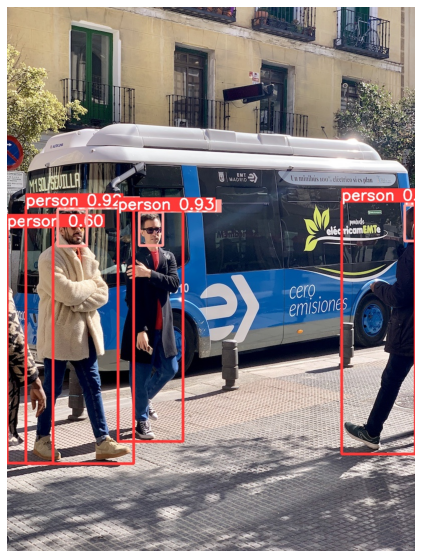

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image = cv2.imread("/content/yolov5/runs/detect/exp81/bus.jpg")
height, width = image.shape[:2]
resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

**Object Detection on Videos. Create a folder under inference/ called "videos", under which you can upload the video file and then provide the file path below**

In [ ]:
!python detect.py --source "/content/gdrive/MyDrive/Colab Notebooks/kexu.mp4" --weights yolov5s.pt --class 0 --conf 0.45

In [ ]:
!cp "/content/yolov5/runs/detect/exp83/kexu.mp4" -r "/content/gdrive/MyDrive"